## TensorFlow CNN Tutorial 

Based on [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) 

### Number of Parameters and Tensor Sizes in a Convolutional Neural Network (CNN)

<https://www.learnopencv.com/number-of-parameters-and-tensor-sizes-in-convolutional-neural-network/>

## Flowchart

The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below. 

![Flowchart](https://github.com/Hvass-Labs/TensorFlow-Tutorials/raw/36229085873d0c2548fc6de5e3a4129e09fec72e/images/02_network_flowchart.png)

The input image is processed in the first convolutional layer using the filter-weights. This results in 16 new images, one for each filter in the convolutional layer. The images are also down-sampled using max-pooling so the image resolution is decreased from 28x28 to 14x14.

These 16 smaller images are then processed in the second convolutional layer. We need filter-weights for each of these 16 channels, and we need filter-weights for each output channel of this layer. There are 36 output channels so there are a total of 16 x 36 = 576 filters in the second convolutional layer. The resulting images are also down-sampled using max-pooling to 7x7 pixels.

The output of the second convolutional layer is 36 images of 7x7 pixels each. These are then flattened to a single vector of length 7 x 7 x 36 = 1764, which is used as the input to a fully-connected layer with 128 neurons (or elements). This feeds into another fully-connected layer with 10 neurons, one for each of the classes, which is used to determine the class of the image, that is, which number is depicted in the image.

The convolutional filters are initially chosen at random, so the classification is done randomly. The error between the predicted and true class of the input image is measured as the so-called cross-entropy. The optimizer then automatically propagates this error back through the Convolutional Network using the chain-rule of differentiation and updates the filter-weights so as to improve the classification error. This is done iteratively thousands of times until the classification error is sufficiently low.

Note that the computation in TensorFlow is actually done on a batch of images instead of a single image, which makes the computation more efficient. This means the flowchart actually has one more data-dimension when implemented in TensorFlow.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
tf.logging.set_verbosity(tf.logging.ERROR)  # or any {DEBUG, INFO, WARN, ERROR, FATAL}

This was developed using Python 3.6 (Anaconda) and TensorFlow version:

In [2]:
tf.__version__

'1.15.0'

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


The MNIST data-set has now been loaded and consists of 70,000 images and associated labels (i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are zero except for one element. The index of this one element is the class-number, that is, the digit shown in the associated image. We also need the class-numbers as integers for the test-set, so we calculate it now.

In [5]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions

The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.

In [6]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

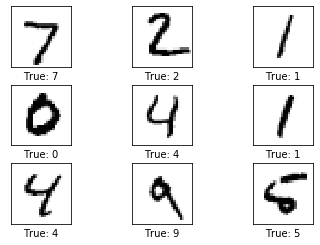

In [8]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## Placeholder variables

Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional array. The data-type is set to `float32` and the shape is set to `[None, img_size_flat]`, where `None` means that the tensor may hold an arbitrary number of images with each image being a vector of length `img_size_flat`.

In [9]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

The convolutional layers expect `x` to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead `[num_images, img_height, img_width, num_channels]`. Note that `img_height == img_width == img_size` and `num_images` can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [10]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes` which is 10 in this case.

In [11]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point.

In [12]:
y_true_cls = tf.argmax(y_true, dimension=1)

## Layers Implementation


We use the `net`-variable to refer to the last layer while building the Neural Network. This makes it easy to add or remove layers in the code if you want to experiment. First we set the `net`-variable to the reshaped input image.

The input image is then input to the first convolutional layer, which has 16 filters each of size 5x5 pixels. 

In [13]:
# layer_conv1
net = tf.layers.conv2d(inputs=x_image, name='layer_conv1', padding='same',
                       filters=16, kernel_size=5, activation=tf.nn.relu)
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

# layer_conv2
net = tf.layers.conv2d(inputs=net, name='layer_conv2', padding='same',
                       filters=36, kernel_size=5, activation=tf.nn.relu)
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

print(net)

Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 7, 7, 36), dtype=float32)


Next we want to add fully-connected layers to the Neural Network, but these require 2-rank tensors as input, so we must first flatten the tensors.

In [14]:
net = tf.layers.flatten(net)

print(net)

Tensor("flatten/Reshape:0", shape=(?, 1764), dtype=float32)


We can now add fully-connected layers to the neural network. 

We need the neural network to classify the input images into 10 different classes. So the final fully-connected layer has `num_classes=10` output neurons.

The output of the final fully-connected layer are sometimes called logits.

In [15]:
net = tf.layers.dense(inputs=net, name='layer_fc1',
                      units=128, activation=tf.nn.relu)
logits = tf.layers.dense(inputs=net, name='layer_fc_out',
                      units=num_classes, activation=None)
print(logits)

Tensor("layer_fc_out/BiasAdd:0", shape=(?, 10), dtype=float32)


We use the softmax function to 'squash' the outputs so they are between zero and one, and so they sum to one.

This tells us how likely the neural network thinks the input image is of each possible class. The one that has the highest value is considered the most likely so its index is taken to be the class-number.

In [16]:
y_pred = tf.nn.softmax(logits=logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

### Loss-Function to be Optimized

To make the model better at classifying the input images, we must somehow change the variables of the Convolutional Neural Network.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the variables of the model.

TensorFlow has a function for calculating the cross-entropy, which uses the values of the `logits`-layer because it also calculates the softmax internally, so as to to improve numerical stability.

In [17]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits)

We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

In [18]:
loss = tf.reduce_mean(cross_entropy)

### Optimization Method

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the Adam optimizer with a learning-rate of 1e-4.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [19]:
opt = tf.train.AdamOptimizer(learning_rate=1e-4)
optimizer = opt.minimize(loss)

### Classification Accuracy

First we create a vector of booleans telling us whether the predicted class equals the true class of each image.

The classification accuracy is calculated by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [20]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Getting the Weights

Further below, we want to plot the weights of the convolutional layers. First we need a list of the variable names in the TensorFlow graph:

In [21]:
#trainable_var_list = []
#for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
#    trainable_var_list.append(var)
#    print(var)

trainable_var_list = tf.trainable_variables()

Each of the convolutional layers has two variables. For the first convolutional layer they are named `layer_conv1/kernel:0` and `layer_conv1/bias:0`. The `kernel` variables are the ones we want to plot further below.

It is somewhat awkward to get references to these variables, because we have to use the TensorFlow function `get_variable()` which was designed for another purpose; either creating a new variable or re-using an existing variable. The easiest thing is to make the following helper-function.

In [22]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'kernel' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('kernel')

    return variable

Using this helper-function we can retrieve the variables. These are TensorFlow objects. In order to get the contents of the variables, you must do something like: `contents = session.run(weights_conv1)` as demonstrated further below.

In [23]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')
print(weights_conv1)
print(weights_conv2)

weights_fc1 = get_weights_variable(layer_name='layer_fc1')
weights_fc_out = get_weights_variable(layer_name='layer_fc_out')
print(weights_fc1)
print(weights_fc_out)

<tf.Variable 'layer_conv1/kernel:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'layer_conv2/kernel:0' shape=(5, 5, 16, 36) dtype=float32_ref>
<tf.Variable 'layer_fc1/kernel:0' shape=(1764, 128) dtype=float32_ref>
<tf.Variable 'layer_fc_out/kernel:0' shape=(128, 10) dtype=float32_ref>


## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [24]:
session = tf.Session()

### Initialize variables

The variables for the TensorFlow graph must be initialized before we start optimizing them.

In [25]:
session.run(tf.global_variables_initializer())

### Get gradients during training

<https://stackoverflow.com/questions/34687761/efficiently-grab-gradients-from-tensorflow>

In [26]:
#grad = opt.compute_gradients(loss, weights_fc_out)[0]
grads = tf.gradients(loss, weights_fc_out)[0]
print(grads)

Tensor("gradients_1/layer_fc_out/MatMul_grad/MatMul_1:0", shape=(128, 10), dtype=float32)


### Hessian Computation

<https://stackoverflow.com/questions/50310532/tensorflow-compute-hessian-with-respect-to-each-sample>

In [27]:
# arg1: our defined function, arg2: list of tf variables associated with the function
hessian = tf.reduce_sum(tf.hessians(loss, weights_fc_out)[0], axis = 2)
print(hessian)

Tensor("Sum:0", shape=(128, 10, 10), dtype=float32)


### Helper-function to perform optimization iterations

There are 55,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to do more optimization iterations.

In [28]:
train_batch_size = 64

This function performs a number of optimization iterations so as to gradually improve the variables of the neural network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.  The progress is printed every 100 iterations.

In [29]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 10 == 0:
            # Calculate the accuracy on the training-set.
            los, acc = session.run([loss, accuracy], feed_dict=feed_dict_train)
            
            grads_vals, hess_vals = session.run([grads, hessian], feed_dict=feed_dict_train)
            
            print(grads_vals.shape)
            print(hess_vals.shape)

            # Message for printing.
            msg = "Iteration: {0:>6}, Training Loss: {1:>1.6}, Training Accuracy: {2:>6.1%}"

            # Print it.
            print(msg.format(i + 1, los, acc))
            

    # Update the total number of iterations performed.
    total_iterations += num_iterations

Below is a function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size.

In [30]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy():

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))


## Performance before any optimization

The accuracy on the test-set is very low because the variables for the neural network have only been initialized and not optimized at all, so it just classifies the images randomly.

In [31]:
print_test_accuracy()

Accuracy on Test-Set: 11.7% (1174 / 10000)


## Performance after 1 optimization iteration

The classification accuracy does not improve much from just 1 optimization iteration, because the learning-rate for the optimizer is set very low.

In [32]:
optimize(num_iterations=1)

(128, 10)
(128, 10, 10)
Iteration:      1, Training Loss: 2.31461, Training Accuracy:  17.2%


In [33]:
print_test_accuracy()

Accuracy on Test-Set: 12.4% (1237 / 10000)


## Performance after 100 optimization iterations

After 100 optimization iterations, the model has significantly improved its classification accuracy.

In [34]:
%%time
optimize(num_iterations=99) # We already performed 1 iteration above.

(128, 10)
(128, 10, 10)
Iteration:     11, Training Loss: 2.23853, Training Accuracy:  34.4%
(128, 10)
(128, 10, 10)
Iteration:     21, Training Loss: 2.21549, Training Accuracy:  34.4%
(128, 10)
(128, 10, 10)
Iteration:     31, Training Loss: 2.14373, Training Accuracy:  51.6%
(128, 10)
(128, 10, 10)
Iteration:     41, Training Loss: 2.04104, Training Accuracy:  56.2%
(128, 10)
(128, 10, 10)
Iteration:     51, Training Loss: 1.93794, Training Accuracy:  56.2%
(128, 10)
(128, 10, 10)
Iteration:     61, Training Loss: 1.78299, Training Accuracy:  70.3%
(128, 10)
(128, 10, 10)
Iteration:     71, Training Loss: 1.66304, Training Accuracy:  62.5%
(128, 10)
(128, 10, 10)
Iteration:     81, Training Loss: 1.4649, Training Accuracy:  84.4%
(128, 10)
(128, 10, 10)
Iteration:     91, Training Loss: 1.32354, Training Accuracy:  79.7%
CPU times: user 16.8 s, sys: 1.03 s, total: 17.8 s
Wall time: 2.07 s


In [35]:
print_test_accuracy()

Accuracy on Test-Set: 81.8% (8180 / 10000)


## Visualization of Weights

### Helper-function for plotting convolutional weights

In [36]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for plotting fully-connected layer weights

In [37]:
from sklearn.decomposition import PCA
def plot_fc_weights(weights_list):
    # Assume weights in weights_list are TensorFlow ops for 2-dim variables
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w_list = session.run(weights_list)
    
    pca = PCA(n_components=2)
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    
    for w in w_list:
            
        print(w.shape)

        principalComponents = pca.fit_transform(w)

        ax.scatter(principalComponents[:,0], principalComponents[:,1], label=w.shape, alpha=0.5)

    ax.legend()
    plt.show()

### Convolution Layer 1

Now plot the filter-weights for the first convolutional layer.

Note that positive weights are red and negative weights are blue.

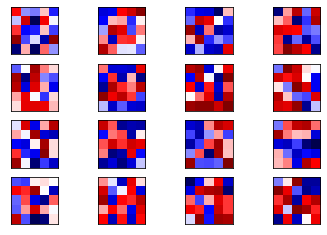

In [38]:
plot_conv_weights(weights=weights_conv1)

### Convolution Layer 2

Now plot the filter-weights for the second convolutional layer.

There are 16 output channels from the first conv-layer, which means there are 16 input channels to the second conv-layer. The second conv-layer has a set of filter-weights for each of its input channels. We start by plotting the filter-weigths for the first channel.

Note again that positive weights are red and negative weights are blue.

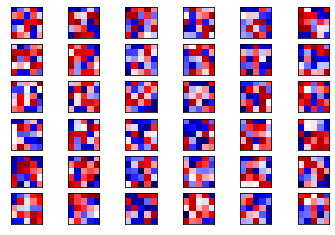

In [39]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

There are 16 input channels to the second convolutional layer, so we can make another 15 plots of filter-weights like this. We just make one more with the filter-weights for the second channel. 

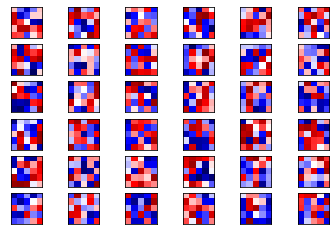

In [40]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

It can be difficult to understand and keep track of how these filters are applied because of the high dimensionality.

Applying these convolutional filters to the images that were ouput from the first conv-layer gives the following images.

Note that these are down-sampled to 14 x 14 pixels which is half the resolution of the original input images, because the first convolutional layer was followed by a max-pooling layer with stride 2. Max-pooling is also done after the second convolutional layer, but we retrieve these images before that has been applied.

(1764, 128)
(128, 10)


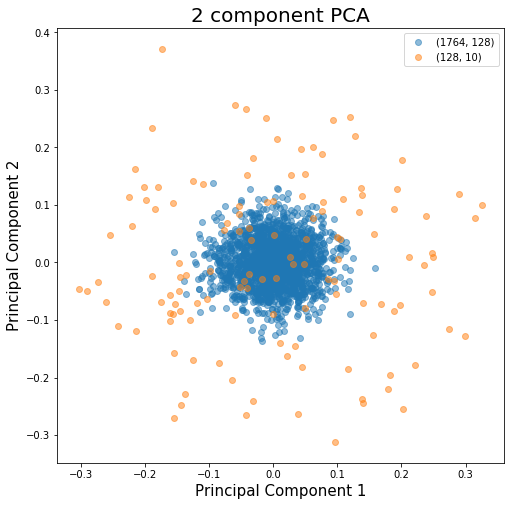

In [41]:
plot_fc_weights(weights_list=[weights_fc1, weights_fc_out])

### Close TensorFlow Session

We are now done using TensorFlow, so we close the session to release its resources.

In [42]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()